In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("FaceRecognition.csv")

In [9]:
data=data.drop(columns='Unnamed: 0')

In [13]:
labels=data.iloc[:,0]
data=data.drop(columns='X1')

In [17]:
data.iloc[-1,-1]

'PrivateTest'

In [37]:
Train_data=data[data['X2306']=='Training'].drop(columns='X2306')
Test_data=data[data['X2306']=='PrivateTest'].drop(columns='X2306')

In [38]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(48, 48),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

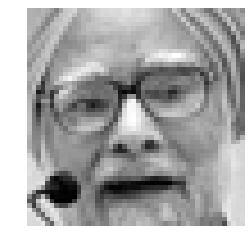

In [41]:
vectortoimg(Train_data.iloc[1,:].values)